In [72]:
using JuMP
using HiGHS
using LinearAlgebra
using Plots

In [73]:

function leer_archivo_tsp(archivo)
    coordenadas = []
    open(archivo, "r") do f
        en_seccion = false
        for linea in eachline(f)
            if occursin("NODE_COORD_SECTION", linea)
                en_seccion = true
                continue
            elseif occursin("EOF", linea)
                break
            end
            
            if en_seccion
                partes = split(linea)
                if length(partes) >= 3
                    id = parse(Int, partes[1])
                    lat = parse(Float64, partes[2])
                    lon = parse(Float64, partes[3])
                    push!(coordenadas, (id, lat, lon))
                end
            end
        end
    end
    return coordenadas
end

# Función para calcular distancias
function calcular_matriz_distancias(coordenadas)
    n = length(coordenadas)
    distancias = zeros(n, n)
    
    for i in 1:n
        for j in 1:n
            if i != j
                lat1, lon1 = coordenadas[i][2], coordenadas[i][3]
                lat2, lon2 = coordenadas[j][2], coordenadas[j][3]
                distancias[i,j] = sqrt((lat2 - lat1)^2 + (lon2 - lon1)^2)
            end
        end
    end
    return distancias
end

# Función para encontrar componentes conexos
function encontrar_componentes_conexos(x_vals, n)
    visitado = falses(n)
    componentes = Vector{Int}[]
    
    for i in 1:n
        if !visitado[i] && any(x_vals[i,:] .> 0.5)
            componente = Int[]
            pila = [i]
            visitado[i] = true
            
            while !isempty(pila)
                actual = pop!(pila)
                push!(componente, actual)
                
                # Solo buscar conexiones salientes
                for j in 1:n
                    if !visitado[j] && x_vals[actual, j] > 0.5
                        push!(pila, j)
                        visitado[j] = true
                    end
                end
            end
            push!(componentes, componente)
        end
    end
    return componentes
end

# Función para extraer el tour
function extraer_tour(x_vals, n)
    tour = Int[]
    if !any(x_vals .> 0.5)
        return collect(1:n)  # Fallback: tour secuencial
    end
    
    # Encontrar ciudad inicial con conexiones
    start_idx = 1
    for i in 1:n
        if any(x_vals[i,:] .> 0.5)
            start_idx = i
            break
        end
    end
    
    ciudad_actual = start_idx
    push!(tour, ciudad_actual)
    visitadas = falses(n)
    visitadas[ciudad_actual] = true
    
    for paso in 1:n-1
        encontrado = false
        # Buscar siguiente ciudad
        for j in 1:n
            if !visitadas[j] && x_vals[ciudad_actual, j] > 0.5
                ciudad_actual = j
                push!(tour, ciudad_actual)
                visitadas[ciudad_actual] = true
                encontrado = true
                break
            end
        end
        
        if !encontrado
            # Buscar cualquier ciudad no visitada
            for j in 1:n
                if !visitadas[j]
                    ciudad_actual = j
                    push!(tour, ciudad_actual)
                    visitadas[ciudad_actual] = true
                    break
                end
            end
        end
    end
    return tour
end



extraer_tour (generic function with 1 method)

In [ ]:

coordenadas = leer_archivo_tsp("../data/input/gr202.tsp")
println("Número de ciudades totales: ", length(coordenadas))

NUM_CIUDADES = 202
coordenadas = coordenadas[1:NUM_CIUDADES]
n = length(coordenadas)

println("Resolviendo para $n ciudades...")

# Calcular matriz de distancias
distancias = calcular_matriz_distancias(coordenadas)
println("Matriz de distancias calculada")


Número de ciudades totales: 202
Resolviendo para 20 ciudades...
Matriz de distancias calculada


In [75]:
model = Model(HiGHS.Optimizer)

# CONFIGURACIÓN MÁS ROBUSTA
set_optimizer_attribute(model, "time_limit", 3600.0)
set_optimizer_attribute(model, "parallel", "on")
set_optimizer_attribute(model, "threads", 4)
set_optimizer_attribute(model, "presolve", "on")
set_optimizer_attribute(model, "mip_rel_gap", 0.1)
set_optimizer_attribute(model, "mip_abs_gap", 50.0)
set_optimizer_attribute(model, "mip_max_nodes", 50000)

# Variables binarias
@variable(model, x[1:n, 1:n], Bin)

# Eliminar self-loops
for i in 1:n
    @constraint(model, x[i,i] == 0)
end

# Restricciones de grado
println("Agregando restricciones de grado...")
@constraint(model, salida[i in 1:n], sum(x[i,j] for j in 1:n) == 1)
@constraint(model, entrada[i in 1:n], sum(x[j,i] for j in 1:n) == 1)

# Función objetivo
@objective(model, Min, sum(distancias[i,j] * x[i,j] for i in 1:n, j in 1:n))

Agregando restricciones de grado...


16.35 x[1,2] + 17.430734350565956 x[1,3] + 19.81111304293628 x[1,4] + 19.252605018542294 x[1,5] + 21.174102106110663 x[1,6] + 21.992184975577118 x[1,7] + 20.940193408848923 x[1,8] + 25.121803279223407 x[1,9] + 25.247138451713692 x[1,10] + 27.76984335569792 x[1,11] + 25.180160841424343 x[1,12] + 22.167546097843125 x[1,13] + 21.338776909654403 x[1,14] + 23.523530772398942 x[1,15] + 18.116768475641564 x[1,16] + 26.682683523214077 x[1,17] + 27.854875695288968 x[1,18] + 27.148548764160484 x[1,19] + 26.03549884292598 x[1,20] + 16.35 x[2,1] + 2.7750315313523917 x[2,3] + 3.690541965619685 x[2,4] + 3.5863770019338457 x[2,5] + 5.227705041411576 x[2,6] + 5.817121281183674 x[2,7] + 4.706846077789245 x[2,8] + 8.792752697534487 x[2,9] + 8.900679749322519 x[2,10] + 11.534994581706572 x[2,11] + 9.044611655565982 x[2,12] + [[...320 terms omitted...]] + 4.391821945388949 x[19,9] + 3.3854541792793436 x[19,10] + 1.3360014970051495 x[19,11] + 2.057182539299804 x[19,12] + 5.14995145608189 x[19,13] + 5.81168

In [76]:
# POST-PROCESAMIENTO
function calcular_costo_tour(tour, distancias)
    n = length(tour)
    costo = 0.0
    for i in 1:n-1
        costo += distancias[tour[i], tour[i+1]]
    end
    costo += distancias[tour[end], tour[1]]
    return costo
end

function mejorar_2opt_rapido(tour, distancias; max_iter=100)
    n = length(tour)
    mejor_tour = copy(tour)
    mejor_costo = calcular_costo_tour(mejor_tour, distancias)
    improved = true
    iter = 0
    
    while improved && iter < max_iter
        improved = false
        for i in 1:n-1
            for j in i+2:min(i+15, n)
                a, b = mejor_tour[i], mejor_tour[i+1]
                c, d = mejor_tour[j], mejor_tour[(j % n) + 1]
                
                ganancia = distancias[a, b] + distancias[c, d] - 
                          distancias[a, c] - distancias[b, d]
                
                if ganancia > 1e-6
                    reverse!(mejor_tour, i+1, j)
                    mejor_costo -= ganancia
                    improved = true
                    break
                end
            end
            if improved; break; end
        end
        iter += 1
    end
    return mejor_tour, mejor_costo
end


mejorar_2opt_rapido (generic function with 1 method)

In [77]:
# ESTRATEGIA DFJ MEJORADA - CORREGIDA
iteracion = 1
max_iteraciones = 150
solucion_valida = false
mejor_costo = Inf
mejor_tour = Int[]
cortes_totales = 0

println("Iniciando optimización DFJ...")

# AGREGAR RESTRICCIONES INICIALES PARA AYUDAR AL SOLVER
println("Agregando restricciones iniciales de subtour...")
for i in 1:min(8, n)
    for j in i+1:min(i+2, n)
        @constraint(model, x[i,j] + x[j,i] <= 1)
    end
end

while iteracion <= max_iteraciones && !solucion_valida
    start_time = time()
    
    println("\n--- Iteración DFJ $iteracion ---")
    
    # Resolver el modelo actual
    println("  Optimizando...")
    optimize!(model)
    
    # VERIFICAR PRIMERO SI HAY SOLUCIÓN ANTES DE ACCEDER A value.(x)
    if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.TIME_LIMIT || has_values(model)
        # SOLO ENTONCES acceder a los valores
        x_vals = value.(x)
        costo_actual = objective_value(model)
        
        # Encontrar componentes conexos
        componentes = encontrar_componentes_conexos(x_vals, n)
        
        solve_time = round(time() - start_time, digits=2)
        println("  Tiempo: $(solve_time)s, Componentes: $(length(componentes)), Costo: $(round(costo_actual, digits=2))")
        
        if length(componentes) == 1
            println(" ¡SOLUCIÓN VÁLIDA ENCONTRADA! en iteración $iteracion")
            solucion_valida = true
            mejor_tour = extraer_tour(x_vals, n)
            mejor_costo = costo_actual
        else
            # ESTRATEGIA DE CORTES MÁS INTELIGENTE
            cortes_agregados = 0
            
            # Ordenar componentes por tamaño
            sort!(componentes, by=length)
            
            for componente in componentes
                if 2 <= length(componente) <= n-2
                    # Restricción de subtour estándar
                    @constraint(model, sum(x[i,j] for i in componente, j in 1:n if !(j in componente)) >= 1)
                    cortes_agregados += 1
                    cortes_totales += 1
                    
                    # Limitar a 5 cortes por iteración
                    if cortes_agregados >= 5
                        break
                    end
                end
            end
            
            println("  Agregados $cortes_agregados cortes (total: $cortes_totales)")
            
            # Guardar la mejor solución hasta ahora
            if costo_actual < mejor_costo
                mejor_costo = costo_actual
                mejor_tour = extraer_tour(x_vals, n)
                println("   Nueva mejor solución: $(round(mejor_costo, digits=2))")
            end
            
            # Condiciones de parada
            if cortes_agregados == 0
                println("   No se pudieron agregar más cortes útiles")
                solucion_valida = true
            end
            
            if cortes_totales >= 100
                println("   Límite de cortes alcanzado")
                solucion_valida = true
            end
        end
    else
        # NO HAY SOLUCIÓN
        solve_time = round(time() - start_time, digits=2)
        println("   No se encontró solución factible en esta iteración")
        println("  Tiempo: $(solve_time)s")
        
        if iteracion == 1
            println("  Intentando con configuración alternativa...")
            set_optimizer_attribute(model, "mip_rel_gap", 0.2)
        else
            break
        end
    end
    
    iteracion += 1
    
    # Parar si estamos tomando demasiado tiempo por iteración
    if time() - start_time > 300 && iteracion > 5
        println("  Límite de tiempo por iteración alcanzado")
        break
    end
end


Iniciando optimización DFJ...
Agregando restricciones iniciales de subtour...

--- Iteración DFJ 1 ---
  Optimizando...
Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 76 rows; 400 cols; 852 nonzeros; 400 integer variables (400 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
56 rows, 380 cols, 792 nonzeros  0s
56 rows, 380 cols, 792 nonzeros  0s

Solving MIP model with:
   56 rows
   380 cols (380 binary, 0 integer, 0 implied int., 0 continuous, 0 domain fixed)
   792 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Node

In [78]:
# RESULTADOS FINALES
if solucion_valida && !isempty(mejor_tour)
    println("\n" * "="^60)
    println(" SOLUCIÓN ÓPTIMA ENCONTRADA")
    
    # Aplicar 2-opt para mejorar
    println("Aplicando 2-opt para mejora local...")
    tour_mejorado, costo_mejorado = mejorar_2opt_rapido(mejor_tour, distancias)
    
    println("Costo final: $(round(costo_mejorado, digits=2))")
    println("Tour (primeras 10 ciudades): $(tour_mejorado[1:min(10, n)])")
    
    # Verificación
    println("\nVERIFICACIÓN:")
    println("- Tour length: $(length(tour_mejorado))")
    println("- Ciudades únicas: $(length(unique(tour_mejorado)))")
    println("- Tour válido: $(length(unique(tour_mejorado)) == n)")
    
    # Mostrar tour detallado
    println("\nTour detallado:")
    for (idx, ciudad_idx) in enumerate(tour_mejorado[1:min(10, n)])
        ciudad_id = coordenadas[ciudad_idx][1]
        lat = coordenadas[ciudad_idx][2]
        lon = coordenadas[ciudad_idx][3]
        println("$idx. Ciudad $ciudad_id: ($lat, $lon)")
    end
    if n > 10
        println("... (y $(n-10) ciudades más)")
    end
    
elseif mejor_costo < Inf
    println("\n" * "="^60)
    println(" MEJOR SOLUCIÓN ENCONTRADA (puede tener subtours)")
    println("="^60)
    println("Mejor costo encontrado: $(round(mejor_costo, digits=2))")
    if !isempty(mejor_tour)
        println("Tour parcial: $(mejor_tour[1:min(10, length(mejor_tour))])")
    end
    
else
    println("\n" * "="^60)
    println(" NO SE PUDO ENCONTRAR SOLUCIÓN")
    println("="^60)
    println("Recomendaciones:")
    println("1. Reduce NUM_CIUDADES a 15")
    println("2. Verifica que la matriz de distancias sea válida")
    println("3. Prueba con un tiempo límite mayor")
end


 SOLUCIÓN ÓPTIMA ENCONTRADA
Aplicando 2-opt para mejora local...
Costo final: 71.19
Tour (primeras 10 ciudades): [1, 2, 5, 4, 8, 6, 7, 9, 10, 17]

VERIFICACIÓN:
- Tour length: 20
- Ciudades únicas: 20
- Tour válido: true

Tour detallado:
1. Ciudad 1: (37.44, -25.4)
2. Ciudad 2: (38.43, -9.08)
3. Ciudad 5: (36.32, -6.18)
4. Ciudad 4: (37.23, -5.59)
5. Ciudad 8: (37.53, -4.46)
6. Ciudad 6: (36.43, -4.25)
7. Ciudad 7: (37.13, -3.41)
8. Ciudad 9: (38.21, -0.29)
9. Ciudad 10: (39.28, -0.22)
10. Ciudad 17: (38.54, 1.26)
... (y 10 ciudades más)


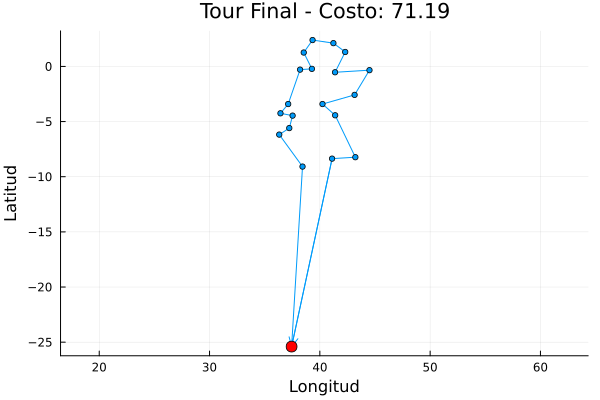

In [79]:
function visualizar_tour(coordenadas, tour, titulo="Tour TSP")
    lats = [c[3] for c in coordenadas]
    lons = [c[2] for c in coordenadas]
    
    tour_lats = lats[tour]
    tour_lons = lons[tour]
    
    push!(tour_lats, tour_lats[1])
    push!(tour_lons, tour_lons[1])
    
    p = plot(tour_lons, tour_lats, 
             line=:arrow, marker=:circle, markersize=3,
             title=titulo, xlabel="Longitud", ylabel="Latitud",
             legend=false, aspect_ratio=:equal)
    
    scatter!([tour_lons[1]], [tour_lats[1]], markersize=6, color=:red)
    
    return p
end

# Visualizar solo si tenemos solución válida
if solucion_valida && !isempty(mejor_tour)
    p = visualizar_tour(coordenadas, mejor_tour, "Tour Final - Costo: $(round(mejor_costo, digits=2))")
    display(p)
end